In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from ray.tune import Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from src.data import IFCNetPlySparse
from src.models.models import MinkowskiFCNN, MinkowskiCE2
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
import torch.nn as nn
import MinkowskiEngine as ME
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/IFCGeomUniform/IFCNetCore")
max_batch_size = 70

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
val_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
test_dataset = IFCNetPlySparse(data_root, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=1, num_workers=8, collate_fn=ME.utils.SparseCollation())
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())
test_loader = DataLoader(test_dataset, batch_size=max_batch_size, num_workers=8, collate_fn=ME.utils.SparseCollation())

In [4]:
log_dir = Path("../logs/IFCGeomUniform/DEFAULT_2021-09-14_15-43-44/")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

print(best_trial_dir)

../logs/IFCGeomUniform/DEFAULT_2021-09-14_15-43-44/DEFAULT_c7430_00000_0_2021-09-14_15-43-44


In [ ]:
model = MinkowskiCE2(3, len(class_names), config["embedding_dim"])
model_state, _ = torch.load(best_trial_dir/"checkpoint_249"/"checkpoint")
model.load_state_dict(model_state)

In [6]:
device = torch.device("cuda")
model.eval()
model.to(device)

MinkowskiCE2(
  (mlp1): Sequential(
    (0): MinkowskiLinear(in_features=3, out_features=16, bias=False)
    (1): MinkowskiBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv1): Sequential(
    (0): MinkowskiConvolution(in=16, out=32, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (down1): Sequential(
    (0): MinkowskiConvolution(in=48, out=32, kernel_size=[1, 1, 1], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv2): Sequential(
    (0): MinkowskiConvolution(in=32, out=48, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeak

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    heatmap = sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for coords, feats, labels in tqdm(loader):
            labels = torch.tensor(labels)
                
            coords, feats, labels = coords.to(device), feats.to(device), labels.to(device)
            tensor = ME.TensorField(feats, coords)

            outputs = model(tensor)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    print(result)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 122/122 [00:09<00:00, 13.37it/s]


{'accuracy_score': 0.8638352638352639, 'balanced_accuracy_score': 0.8896489815672648, 'precision_score': 0.8732273540778082, 'recall_score': 0.8638352638352639, 'f1_score': 0.8659119733940998}


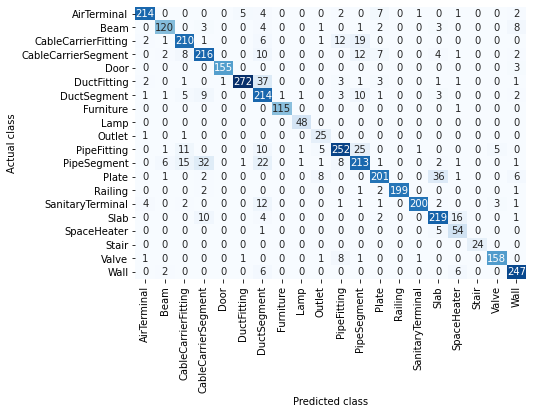

In [8]:
eval(model, train_loader, device, class_names);

100%|██████████| 53/53 [00:04<00:00, 12.29it/s]


{'accuracy_score': 0.8541416566626651, 'balanced_accuracy_score': 0.8874579508265283, 'precision_score': 0.8638745390365841, 'recall_score': 0.8541416566626651, 'f1_score': 0.8554920663787808}


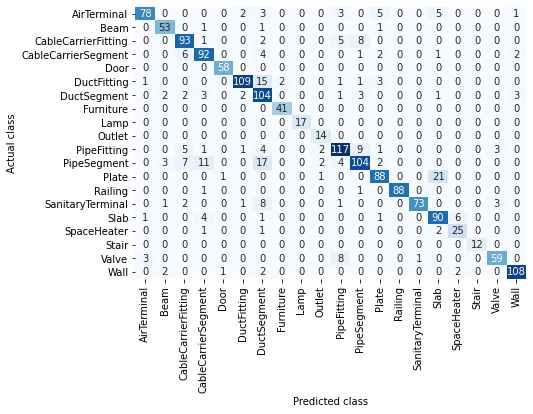

In [9]:
eval(model, val_loader, device, class_names);

100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


{'accuracy_score': 0.8158890290037831, 'balanced_accuracy_score': 0.8301606935099011, 'precision_score': 0.8277658055034153, 'recall_score': 0.8158890290037831, 'f1_score': 0.817962167707173}


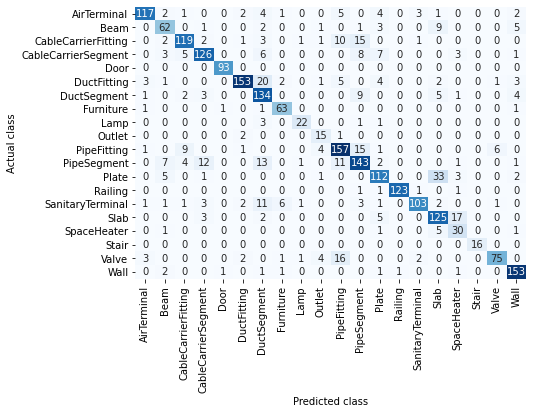

In [8]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/ifcgeomuniform_confusion.svg")

In [17]:
np.savez("IFCGeomUniformProbs.npz", labels=test_labels, probs=test_probs)

In [8]:
coords, feats, labels = next(iter(train_loader))
coords, feats = coords.to(device), feats.to(device)
dummy_input = ME.TensorField(feats, coords)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 1000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
print(std_syn)

9.945668354034424
0.7573950039568617


In [8]:
coords, feats, labels = next(iter(test_loader))
coords, feats = coords.to(device), feats.to(device)
dummy_input = ME.TensorField(feats, coords)

repetitions=100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(dummy_input)
        ender.record()
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions*max_batch_size)/total_time
print('Final Throughput:',Throughput)

Final Throughput: 1501.0259422597735


In [9]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [10]:
wrong_pred_dir = Path("../data/external/IFCGeomUniform/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore.Obj").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.files[i].stem}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.files[i]
    shutil.copy(str(raw_data_dict[filename.stem]), str(target_dir / f"{filename.stem}_{prediction_str}.obj"))

0040c7bf0e474141bb19bdf8ed59e080, Label: IfcAirTerminal, Prediction: IfcPipeFitting
074813d22a894bd299966b7fb2163749, Label: IfcAirTerminal, Prediction: IfcDuctSegment
11cabe633ca745858610da5ba74dfaaf, Label: IfcAirTerminal, Prediction: IfcPipeFitting
334a4570ea2c44748251140812d50117, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
39dcfc4c0b2d43b688646ba08cdb08e7, Label: IfcAirTerminal, Prediction: IfcBeam
59764e0479414af0a18096316ddd5681, Label: IfcAirTerminal, Prediction: IfcBeam
5bfd5d508e084fa6a436046276beb8df, Label: IfcAirTerminal, Prediction: IfcDuctSegment
5c4c4a4d2a11431b92a19b0313f8ea68, Label: IfcAirTerminal, Prediction: IfcPipeFitting
613c65c4ab2742319d1511eee9c9c1ee, Label: IfcAirTerminal, Prediction: IfcPlate
71059417b8f4400ca102c84ae1a0f421, Label: IfcAirTerminal, Prediction: IfcSlab
7a225741d47f444a949229e262a9c086, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
7ac5c781e86644d1a9e95b8e2db000b0, Label: IfcAirTerminal, Prediction: IfcDuctFitting
923040fc0

50b88d6e73d64189bdedec11f27e205b, Label: IfcPipeFitting, Prediction: IfcCableCarrierFitting
5845f8d8c0304530a3b059b9322f8c7b, Label: IfcPipeFitting, Prediction: IfcValve
5a63dfeb692b4b22b826f91b620a19c3, Label: IfcPipeFitting, Prediction: IfcCableCarrierFitting
7ac3f13701014d2688991e10fd2b80b7, Label: IfcPipeFitting, Prediction: IfcPipeSegment
8d887184a669412dafca2207e5afda08, Label: IfcPipeFitting, Prediction: IfcCableCarrierFitting
91a5d55d8b714bdc93f9cf39cd017204, Label: IfcPipeFitting, Prediction: IfcPipeSegment
9dd8843a72364f009d5aed19b1f34309, Label: IfcPipeFitting, Prediction: IfcOutlet
ab8917f39e504d91a95f3a6d34c673b5, Label: IfcPipeFitting, Prediction: IfcCableCarrierFitting
ad6baef8bf354d90b25cf13b64f59bd6, Label: IfcPipeFitting, Prediction: IfcPipeSegment
b5b7ae9e0e9d406fbbbc733b7fa70c8d, Label: IfcPipeFitting, Prediction: IfcOutlet
b936691cbbe8452c9ce25d3753eeb11c, Label: IfcPipeFitting, Prediction: IfcPipeSegment
bb11dee591dd4846a3e7d667288ae6ea, Label: IfcPipeFitting, Pre

7d6b42a2a77343b8b696a29794efdd39, Label: IfcSpaceHeater, Prediction: IfcPlate
b3e55fc67ec848c99d0b9dcd8a406e14, Label: IfcSpaceHeater, Prediction: IfcSlab
c88febe9aa214a749fff5f538918f962, Label: IfcSpaceHeater, Prediction: IfcSlab
f3ab8950115e479a93bd9e0b67f64026, Label: IfcSpaceHeater, Prediction: IfcSlab
0e37101cf06e4098a12e33f441b1a86b, Label: IfcValve, Prediction: IfcPipeFitting
1629e2d9b61b468a87842d93ed6ec4e0, Label: IfcValve, Prediction: IfcPipeFitting
265744cffdb248f5a6e4ed68be2a53f6, Label: IfcValve, Prediction: IfcOutlet
323364a1b98b4f868d1576e647f2125c, Label: IfcValve, Prediction: IfcPipeFitting
34e77002c8ff44c68385082485098535, Label: IfcValve, Prediction: IfcAirTerminal
431b856a172140d38129304c1bd73fe7, Label: IfcValve, Prediction: IfcAirTerminal
4363c37205664516af4054f1f40ef32d, Label: IfcValve, Prediction: IfcDuctFitting
47ae43d3a16f4002b86ecf02219c98d7, Label: IfcValve, Prediction: IfcPipeFitting
55077c95482843169f1f29f76ac627fd, Label: IfcValve, Prediction: IfcOutlet